In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence

In [3]:
phase = tf.placeholder_with_default(True, shape=(), name='learning_phase')

In [4]:
class BNFlow:
    def __init__(self, dim=None, name='BNFlow', output=None):
        self.dim = dim
        self.name = name
        self.output = output
        self.gamma = 0.99
        if output is not None:
            self.mask = np.zeros(dim, np.bool)
    
    def _update_stats(self, inp_tensor):
        mu = tf.get_variable('mu', shape=inp_tensor.shape[1:], trainable=False)
        sigma2 = tf.get_variable('sigma2', trainable=False, initializer=tf.ones(inp_tensor.shape[1:]))
        
        offset = tf.get_variable('offset', shape=mu.shape)
        scale = tf.get_variable('scale', initializer=tf.zeros(inp_tensor.shape[1:]))
        scale = tf.identity(tf.log1p(tf.exp(scale)), name='scale')
        
        mean = tf.reduce_mean(inp_tensor, axis=0)
        mean2 = tf.reduce_mean(inp_tensor**2, axis=0)
        
        if not hasattr(self, 'ops'):
            op1 = mu.assign(mu*self.gamma + mean*(1 - self.gamma))
            op2 = sigma2.assign(sigma2*self.gamma + (mean2 - mean**2)*(1-self.gamma))
            self.ops = [op1, op2]
        
        self.collected = [mu, sigma2]
        self.adjust = [offset, scale]
        self.stats = [mean, mean2-mean**2]
        
    def __call__(self, inp_flows=None, inverse=False):
        
        if isinstance(inp_flows, FlowSequence):
            prev_flow_output = inp_flows[-1].output
            dim = int(inp_flows[-1].dim)
        elif isinstance(inp_flows, NVPFlow):
            prev_flow_output = inp_flows.output
            dim = inp_flows.dim
            inp_flows = FlowSequence([inp_flows])
        else:
            raise ValueError('Input flow must be either a flowsequence or a flow')
        
        if hasattr(inp_flows[-1],'mask'):
            self.mask = inp_flows[-1].mask
            
        self.dim = dim

        out_flows = inp_flows.add(self)
                
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            
            self._update_stats(prev_flow_output)
            
            mean = tf.where(phase, self.stats[0], self.collected[0])
            var = tf.where(phase, self.stats[1], self.collected[1])
            
            if not inverse:
                self.output = self.adjust[0] + self.adjust[1]*(prev_flow_output - mean) / tf.sqrt(var)
            else:
                self.output = (prev_flow_output - self.adjust[0])*tf.sqrt(var) / self.adjust[1] + mean
            
            self.logj =  tf.reduce_sum(tf.log(self.adjust[1]), axis=-1, name='logj')
            self.logj -= 0.5*tf.reduce_sum(tf.log(var), axis=-1, name='logj')
            
        return out_flows

In [5]:
inp = tf.placeholder(tf.float32, [None, 2])

In [6]:
flow = NVPFlow(2, 'init_flow', inp)

for i in range(0, 16):
    flow = NVPFlow(name=str(i))(flow)
    if i % 2 == 1:
        flow = BNFlow(name=str(i))(flow)

In [7]:
flow[-1].output /= 8

In [8]:
flow[-1].logj.shape

TensorShape([])

In [9]:
flows = FlowSequence(flow[1:])

In [10]:
logj = flows.calc_logj()

In [11]:
logj

<tf.Tensor 'add_23:0' shape=(?,) dtype=float32>

In [12]:
z = flows[-1].output
gain = tf.reduce_sum(-(z**2)/2, axis=-1) + logj
gain = tf.reduce_mean(gain)

In [13]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float32>

In [14]:
train_op = tf.train.AdamOptimizer(0.001).minimize(-gain)
train_op = [train_op] + flows.ops

In [31]:
X, _ = make_moons(n_samples=1024, noise=0.13)

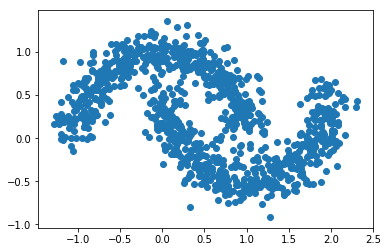

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-5.7896214

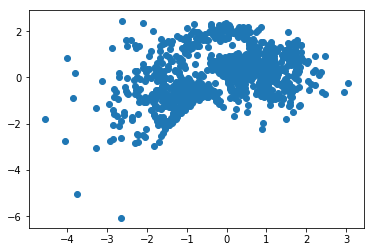

In [32]:
ver = z.eval({inp:X, phase: False})
plt.scatter(ver[:,0], ver[:,1])
plt.show()

In [29]:
for _ in range(1000):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X}).mean())

4.46262
4.45525
4.40605
4.40143
4.42273
4.53122
4.42453


KeyboardInterrupt: 

In [25]:
inverse = flows.apply(inp*8, inverse=True)

In [33]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [34]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

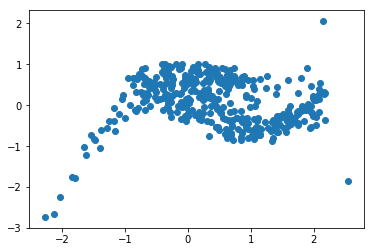

In [35]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()